# EMBEDDINGS, LATENT SPACE, AND REPRESENTATIONS

In deep learning, we often use terms like embedding vectors, representations, and latent space. What do these concepts have in common, and how do they differ? Though these terms are often used interchangeably, we can make subtle distinctions between them.

- **Embedding vectors** represent input data where similar items are close to each other.
- **Latent vectors** are intermediate representations learned by a neural network.
- **Representations** are encoded versions of the original input.
  
Let’s explore each concept in detail.

## Embeddings

Embedding vectors reduce high-dimensional data to low-dimensional continuous vectors while maintaining key properties, like similarity. These embeddings can be learned from categorical data or dense data such as images.

### Example 1: Visualizing Word Embeddings with Sentence Transformers


In [1]:
!pip install -U sentence-transformers
!pip install scikit-learn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 249.1/249.1 kB 14.8 MB/s eta 0:00:00


In [12]:
from sentence_transformers import SentenceTransformer

# Load a pre-trained transformer model for embeddings
model = SentenceTransformer('all-MiniLM-L6-v2')

# Define your vocabulary (words or sentences)
vocabulary = ['strawberry', 'orange', 'banana', 'fruit', 'car', 'vehicle', 'train', 'bus', 'king', 'queen', 'man', 'woman']

# Get embeddings for each word or sentence
embeddings = model.encode(vocabulary)

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


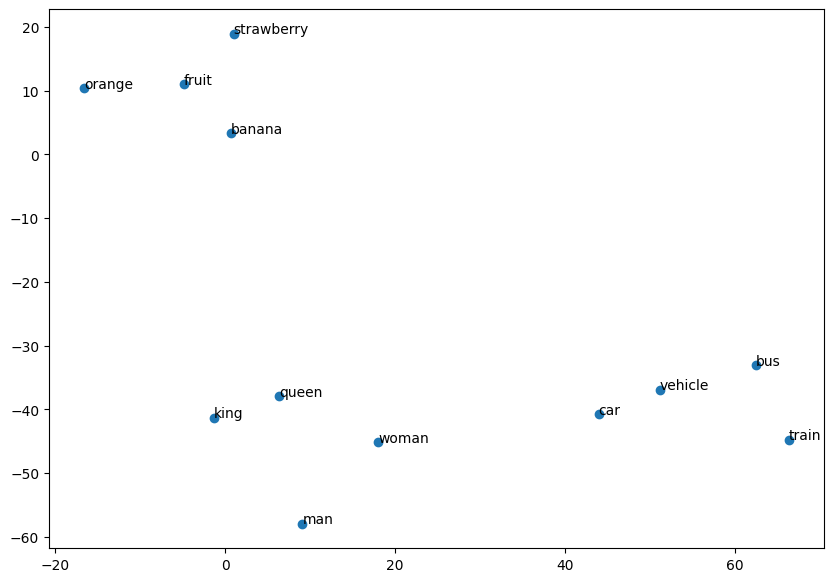

In [14]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# Reduce the embeddings to 2D using t-SNE with lower perplexity
tsne = TSNE(n_components=2, learning_rate='auto',init='random',perplexity=3)
reduced_embeddings = tsne.fit_transform(embeddings)

# Visualize the embeddings
plt.figure(figsize=(10, 7))
plt.scatter(reduced_embeddings[:, 0], reduced_embeddings[:, 1])

# Annotate the points with the corresponding words
for i, word in enumerate(vocabulary):
    plt.annotate(word, (reduced_embeddings[i, 0], reduced_embeddings[i, 1]))

plt.show()

### Example 2: Visualizing Image Embeddings from MNIST with a Convolutional Neural Network (CNN)

Using device: cuda


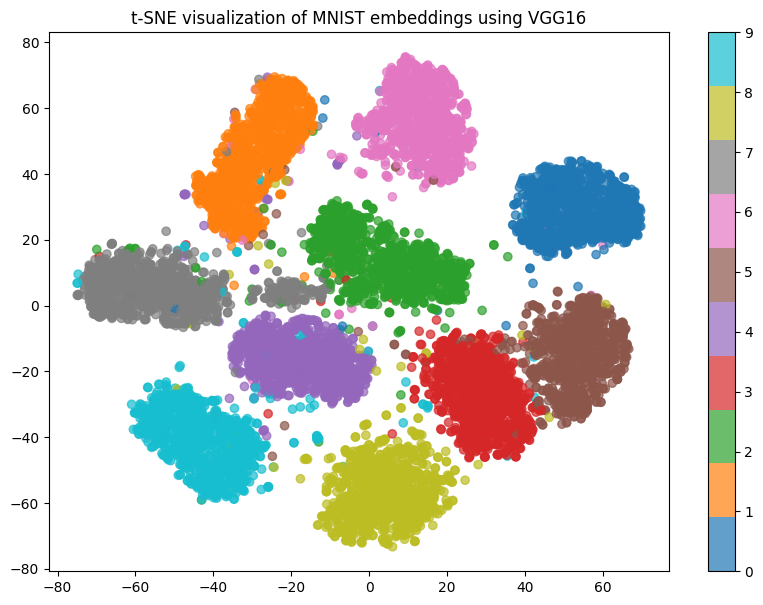

In [16]:
import torch
import torch.nn as nn
from torchvision import datasets, transforms, models
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# Check if GPU is available and set the device accordingly
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'Using device: {device}')

# Define the transformation to convert the MNIST images to 3-channel images and resize them to match VGG input
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize to 224x224, required for VGG16
    transforms.Grayscale(3),  # Convert MNIST 1-channel to 3-channel (RGB)
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Load the MNIST dataset
test_dataset = datasets.MNIST(root='./data', train=False, transform=transform, download=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=64, shuffle=False)

# Load a pre-trained VGG16 model
model = models.vgg16(pretrained=True)

# Remove the final classification layer to get embeddings
model = torch.nn.Sequential(*(list(model.children())[:-1]))

# Move the model to the designated device (GPU or CPU)
model = model.to(device)

# Set the model to evaluation mode
model.eval()

# Extract embeddings from the test set
embeddings_list = []
labels_list = []

with torch.no_grad():
    for data, target in test_loader:
        # Move data to the device
        data = data.to(device)
        target = target.to(device)

        # Forward pass through the model to get embeddings
        embeddings = model(data)
        embeddings = embeddings.view(embeddings.size(0), -1)  # Flatten the embeddings
        embeddings_list.append(embeddings.cpu())  # Move embeddings back to CPU for further processing
        labels_list.append(target.cpu())

# Concatenate all embeddings and labels
embeddings = torch.cat(embeddings_list).numpy()
labels = torch.cat(labels_list).numpy()

# Apply t-SNE to reduce the dimensionality of the embeddings to 2D
tsne = TSNE(n_components=2, random_state=42)
reduced_embeddings = tsne.fit_transform(embeddings)

# Visualize the 2D embeddings
plt.figure(figsize=(10, 7))
plt.scatter(reduced_embeddings[:, 0], reduced_embeddings[:, 1], c=labels, cmap='tab10', alpha=0.7)
plt.colorbar()
plt.title('t-SNE visualization of MNIST embeddings using VGG16')
plt.show()

## Latent Space

Latent space is the space in which compressed representations of data reside. Latent vectors, learned by a neural network, are useful for generating new data or reconstructing inputs, as seen in autoencoders.

### Example: Programming an Autoencoder and Visualizing Latent Space with MNIST

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# Check if GPU is available and set the device accordingly
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'Using device: {device}')

# Define the Autoencoder
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(784, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 32)  # Latent space
        )
        self.decoder = nn.Sequential(
            nn.Linear(32, 64),
            nn.ReLU(),
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Linear(128, 784),
            nn.Sigmoid()  # Output layer
        )

    def forward(self, x):
        latent = self.encoder(x)
        reconstructed = self.decoder(latent)
        return reconstructed, latent

# Setup for MNIST dataset
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])
dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
data_loader = torch.utils.data.DataLoader(dataset, batch_size=32, shuffle=True)

# Initialize the autoencoder and move it to the device
autoencoder = Autoencoder().to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(autoencoder.parameters(), lr=0.001)

# Train the autoencoder
for epoch in range(10):
    for images, _ in data_loader:
        images = images.view(images.size(0), -1).to(device)  # Flatten images and move to device
        outputs, latents = autoencoder(images)
        loss = criterion(outputs, images)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    print(f'Epoch {epoch+1}, Loss: {loss.item()}')

# Extracting and visualizing the latent space
latent_vectors = []
labels = []

with torch.no_grad():
    for images, targets in data_loader:
        images = images.view(images.size(0), -1).to(device)
        _, latents = autoencoder(images)
        latent_vectors.extend(latents.cpu().detach().numpy())  # Move latents back to CPU for t-SNE
        labels.extend(targets.numpy())


Using device: cuda
Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:00<00:00, 16431730.04it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 498293.69it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:00<00:00, 4541428.31it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 4298404.51it/s]


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw

Epoch 1, Loss: 0.9281029105186462
Epoch 2, Loss: 0.9225049018859863
Epoch 3, Loss: 0.9274274110794067
Epoch 4, Loss: 0.9192535877227783
Epoch 5, Loss: 0.9190880656242371
Epoch 6, Loss: 0.9268443584442139
Epoch 7, Loss: 0.9257122278213501
Epoch 8, Loss: 0.9235482811927795
Epoch 9, Loss: 0.9281651973724365
Epoch 10, Loss: 0.9158267974853516


AttributeError: 'list' object has no attribute 'shape'

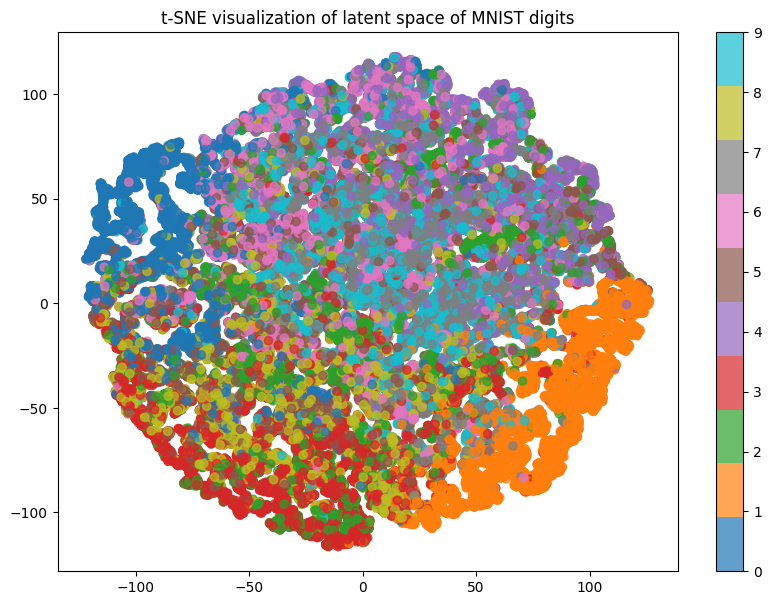

In [2]:
import numpy as np

tsne = TSNE(n_components=2, random_state=42)
reduced_latents = tsne.fit_transform(np.array(latent_vectors))

# Visualize the t-SNE of latent space
plt.figure(figsize=(10, 7))
scatter = plt.scatter(reduced_latents[:, 0], reduced_latents[:, 1], c=labels, cmap='tab10', alpha=0.7)
plt.colorbar(scatter)
plt.title('t-SNE visualization of latent space of MNIST digits')
plt.show()

## Representation

A representation is an encoded version of the original input that can take various forms, such as embeddings, latent vectors, or even simple encodings like one-hot vectors.

### Example: One-Hot Encoding vs. Learned Representations

In [2]:
import torch
import torch.nn as nn

# One-hot encoding of a categorical variable with 5 classes
one_hot = torch.eye(5)[[1, 3, 4]]  # Encoding categories 1, 3, 4

# Embedding layer to map one-hot to dense vector
embedding_layer = nn.Embedding(5, 3)  # 5 categories, embedding of size 3
embedding_vectors = embedding_layer(torch.LongTensor([1, 3, 4]))

print("One-hot Encoded Vectors:")
print(one_hot)
print("Embedding Vectors:")
print(embedding_vectors)


One-hot Encoded Vectors:
tensor([[0., 1., 0., 0., 0.],
        [0., 0., 0., 1., 0.],
        [0., 0., 0., 0., 1.]])
Embedding Vectors:
tensor([[-1.5065,  0.8503,  0.9195],
        [ 1.0450,  0.9560, -0.7647],
        [-1.7090,  0.7112, -1.6332]], grad_fn=<EmbeddingBackward0>)
